# bulk RNA-seq analysis
    Author: Lanting Li
    Data preparation and some useful plotting functions
    
This workbook using R 4.1 with Jupyter notebook. An example of my working environment (conda): `/bulkRNA/config/rjupyterenv.yml`. Useful intermediate data can be found in `/bulkRNA/data/`.

## Import packages

In [1]:
# Require libraries
library(tidyverse)
library(matrixStats)
require(gridExtra)
library(scales)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




## Default settings and file directory

In [2]:
# Default bin size
bin_size <- 250000
chroms <- paste0("chr", c(1:22, "X"))

parental_subclones <- paste0("SP", c(1:10))
primary_clones <- paste0("SP", c(31:42))
# Not including "control" here
samples <- c(paste0("SP", c(1:10, 31:42)))

# Gene ID of PCDH7, the only well expressed gene in chr4 28-36mb
g <- "ENSG00000169851.15"

**All samples:**
- 1-10 (refer to `parental_subclones`): wildtype clones
- 31-42 (refer to `primary_clones`): bridge clones
- control: widtype clone. We don't have DNA copy number of this sample. Copy number is set to 2 except for chr10 after 61mb to be trisomy. (There happens that in 12 there is also a gain but we didn't focus on that here.)

In [3]:
# File location
root_dir <- "/Users/lantingli/Documents/Work/DFCI/stam_project/nature2023/bulkRNA/" # CHANGE THIS ROOT DIR
data_dir <- paste0(root_dir, "data/")
# RNA feature counts, of all 43 samples by gene
feature_counts_dir <- paste0(data_dir, "feature_counts_renamed.rds")
# Allele specific expression, four tables
ase_dir <- paste0(data_dir, "bulk_RNAseq_data_subclone/ASE.bygene.rds")
# Sample information
dna_seq_id_dir <- paste0(data_dir, "DNAseq_IDs_key_clones.csv")
filtered_genes_dir <- paste0(data_dir, "selected_genes.rds")

# Load RNA feature counts
feature_counts <- readRDS(feature_counts_dir)

# Load sample information
dna_seq_id <- read.table(dna_seq_id_dir, sep=",", header = T)
rownames(dna_seq_id) <- dna_seq_id$ID

filtered_genes <- readRDS(filtered_genes_dir)
ASE <- readRDS(ase_dir)

# Aggregated DNA copy number of all samples together
# Total DNA copy number, binned to 250kb
cn_250kb <- readRDS(paste0(data_dir, "cn_250kb.rds"))
# Allele specific DNA copy number, also binned to 250kb
cn_ase <- readRDS(paste0(data_dir, "cn_ase.rds"))

## TPM and transcriptional fold change, total and allele-specific

In [4]:
# Combine chr10 arms to chr10
combine_chr10 <- function(df){
    result <- df %>% mutate(chr = case_when(
        chr == "chr10a" ~ "chr10",
        chr == "chr10b" ~ "chr10",
        TRUE ~ chr))
    return(result)
}

rename_control <- function(df){
    result <- df %>% rename(control = "13-parent")
    return(result)
}

# This function helps rename primary clones to SP##
# RNA feature counts table is already renamed.
# Allele-specific expression tables, if needs, require renaming.
df_rename_id <- function(df){
    df <- df %>% 
        rename(SP31 = "1-B4") %>%
        rename(SP32 = "4-E5") %>%
        rename(SP33 = "5-E8") %>%
        rename(SP34 = "2-F2") %>%
        rename(SP35 = "3-F3") %>%
        rename(SP36 = "11-F9") %>%
        rename(SP37 = "12-F11") %>%
        rename(SP38 = "6-K2") %>%
        rename(SP39 = "7-K11") %>%
        rename(SP40 = "8-N6") %>%
        rename(SP41 = "9-N11") %>%
        rename(SP42 = "10-O16")
    return(df)
}

df_preprocessing <- function(df){
    result <- combine_chr10(df)
    result <- rename_control(result)
    result <- df_rename_id(result)
    return(result)
}

# Calculate Transcripts per Million using feature counts
fc_to_tpm <- function(fc, samples){
    tfc <- fc %>% mutate(chr_loc = (start+end)/2)
    tfc <- tfc %>% mutate(kb_width = width/1000)
    mat <- tfc %>% select(all_of(samples))
    rpk <- mat/tfc$kb_width # Calculate reads per kilobase
    tpm <- data.frame(matrix(nrow=dim(tfc)[1], ncol=0))
    for(sample in samples){
        div_fac <- sum(rpk[[paste0(sample)]])/(10^6)
        tpm[, paste0("tpm_", sample)] <- rpk[[paste0(sample)]]/div_fac
    }
    tpm$gene_id <- tfc$gene_id
    return(tpm)
}

In [5]:
# Calculate raw TPM, merge with DNA copy number
tpm_all_genes <- fc_to_tpm(feature_counts, c(samples, "control"))
df_all_genes <- left_join(feature_counts %>% select(!all_of(c(samples, "control"))), 
                          tpm_all_genes, by = "gene_id") %>%
    mutate(chrom = substr(chr, 4, nchar(chr))) %>%
    mutate(chr_loc = start %/% bin_size * bin_size) %>% 
    left_join(cn_250kb, by = c("chr","chr_loc")) %>% 
    left_join(cn_ase, by = c("chr","chr_loc"))

In [6]:
# AF: allelic fraction
# Use allelic fraction x RNA tpm -> allele-specific tpm
af <- df_preprocessing(ASE$AF)
new_colnames <- c()
for(name in colnames(af)){
    if(name %in% c(samples, "control")){
        new_colnames <- c(new_colnames, paste0("af_",name))
    }
    else
        new_colnames <- c(new_colnames, name)
}
colnames(af) <- new_colnames

In [7]:
df_all_genes <- df_all_genes %>% 
    left_join(af %>% select("gene_id", all_of(paste0("af_", c(samples, "control")))), 
              by = "gene_id")

In [8]:
# Calculate Allelic Raw TPM
for(sample in c(samples, "control")){
    # AS TPM
    df_all_genes[[paste0("tpm_A_", sample)]] <- df_all_genes[[paste0("tpm_", sample)]] * df_all_genes[[paste0("af_",sample)]]
    df_all_genes[[paste0("tpm_B_", sample)]] <- df_all_genes[[paste0("tpm_", sample)]] * ( 1 - df_all_genes[[paste0("af_",sample)]])
}

In [9]:
# Raw TPM for wildtype parental (mean of 10 parental subclones)
df_all_genes$tpm_parental <- df_all_genes %>% select(all_of(paste0("tpm_", parental_subclones))) %>% rowMeans()
df_all_genes$tpm_A_parental <- df_all_genes %>% select(all_of(paste0("tpm_A_", parental_subclones))) %>% rowMeans()
df_all_genes$tpm_B_parental <- df_all_genes %>% select(all_of(paste0("tpm_B_", parental_subclones))) %>% rowMeans()

In [10]:
# Raw TPM Ratio
for(sample in parental_subclones){
    df_all_genes[[paste0("rawratio_", sample)]] <- df_all_genes[[paste0("tpm_", sample)]] / df_all_genes[["tpm_parental"]]
    df_all_genes[[paste0("rawratio_A_", sample)]] <- df_all_genes[[paste0("tpm_A_", sample)]] / df_all_genes[["tpm_A_parental"]]
    df_all_genes[[paste0("rawratio_B_", sample)]] <- df_all_genes[[paste0("tpm_B_", sample)]] / df_all_genes[["tpm_B_parental"]]
}
for(sample in primary_clones){
    df_all_genes[[paste0("rawratio_", sample)]] <- df_all_genes[[paste0("tpm_", sample)]] / df_all_genes[["tpm_control"]]
    df_all_genes[[paste0("rawratio_A_", sample)]] <- df_all_genes[[paste0("tpm_A_", sample)]] / df_all_genes[["tpm_A_control"]]
    df_all_genes[[paste0("rawratio_B_", sample)]] <- df_all_genes[[paste0("tpm_B_", sample)]] / df_all_genes[["tpm_B_control"]]
}

In [11]:
# Global Normalization Factor

# All-gene TPM, extreme values exclude
extreme_tpm_genes <- c()
for(sample in c(samples, "control")){
    extreme_tpm_genes <- union(extreme_tpm_genes, tpm_all_genes[tpm_all_genes[[paste0("tpm_", sample)]]>1e+3, "gene_id"])
    extreme_tpm_genes <- union(extreme_tpm_genes, tpm_all_genes[tpm_all_genes[[paste0("tpm_", sample)]]<1, "gene_id"])
}
cat("Number of extreme-tpm genes:", length(extreme_tpm_genes), "\n")

strict_mono_allelic_genes <- rbind(af %>% filter(af_control == 0), af %>% filter(af_control == 1)) %>%
    rbind(af %>% filter(is.na(af_control)))
strict_mono_allelic_genes <- strict_mono_allelic_genes$gene_id
cat("Number of strict mono-allelic genes:", length(strict_mono_allelic_genes), "\n")

cat("Number of overlap:", length(intersect(strict_mono_allelic_genes, extreme_tpm_genes)), "\n")

gn_genes <- setdiff(feature_counts$gene_id, union(extreme_tpm_genes, strict_mono_allelic_genes))
cat("Number of genes to include when calculate global normalization factor:", length(gn_genes), "\n\n")

tpm_gn <- fc_to_tpm(feature_counts %>% filter(gene_id %in% gn_genes), c(samples, "control"))
df_gn <- left_join(feature_counts %>% filter(gene_id %in% gn_genes) %>% 
                   select(!all_of(c(samples, "control"))), tpm_gn, by = "gene_id") %>%
    mutate(chrom = substr(chr, 4, nchar(chr))) %>%
    mutate(chr_loc = start %/% bin_size * bin_size) %>% 
    left_join(cn_250kb, by = c("chr","chr_loc"))

# Calculate tpm normalized by copy number (total)
for(sample in c(samples, "control")){
    df_gn[[paste0("cntpm_", sample)]] <- df_gn[[paste0("tpm_", sample)]] / df_gn[[paste0("cn_",sample)]]
}

norm_factor <- data.frame(sample = character(), factor = numeric())
for(sample in c(samples, "control")){
    cat(paste0("Sample #", sample, ", Median of copy-number normalized tpm: ", median(df_gn[[paste0("cntpm_", sample)]], na.rm=T), "\n"))
    norm_factor <- norm_factor %>% add_row(sample = sample, factor = median(df_gn[[paste0("cntpm_", sample)]], na.rm = T))
}
saveRDS(norm_factor, paste0(data_dir, "norm_factor.rds"))

Number of extreme-tpm genes: 11643 
Number of strict mono-allelic genes: 12288 
Number of overlap: 9194 
Number of genes to include when calculate global normalization factor: 6814 

Sample #SP1, Median of copy-number normalized tpm: 23.5162885027608
Sample #SP2, Median of copy-number normalized tpm: 24.0719572649728
Sample #SP3, Median of copy-number normalized tpm: 24.4930639519936
Sample #SP4, Median of copy-number normalized tpm: 24.187514828208
Sample #SP5, Median of copy-number normalized tpm: 21.661918583981
Sample #SP6, Median of copy-number normalized tpm: 24.376198979207
Sample #SP7, Median of copy-number normalized tpm: 24.0731609576606
Sample #SP8, Median of copy-number normalized tpm: 24.2753550407154
Sample #SP9, Median of copy-number normalized tpm: 24.5585034646474
Sample #SP10, Median of copy-number normalized tpm: 22.9961962157255
Sample #SP31, Median of copy-number normalized tpm: 28.0035624076962
Sample #SP32, Median of copy-number normalized tpm: 28.4741131066851
S

In [12]:
# CN and GN normalized TPM
for(sample in c(samples, "control")){
    # Total TPM, CN Normalized
    df_all_genes[[paste0("cntpm_", sample)]] <- df_all_genes[[paste0("tpm_", sample)]] / df_all_genes[[paste0("cn_",sample)]]
    # AS TPM, CN Normalized
    df_all_genes[[paste0("cntpm_A_", sample)]] <- df_all_genes[[paste0("tpm_A_", sample)]] / df_all_genes[[paste0("cn_A_",sample)]]
    df_all_genes[[paste0("cntpm_B_", sample)]] <- df_all_genes[[paste0("tpm_B_", sample)]] / df_all_genes[[paste0("cn_B_",sample)]]
    # Total TPM, CN & Global Normalized
    df_all_genes[[paste0("gncntpm_", sample)]] <- df_all_genes[[paste0("cntpm_", sample)]] / norm_factor[norm_factor$sample==sample,"factor"]
    # AS TPM, CN & Global Normalized
    df_all_genes[[paste0("gncntpm_A_", sample)]] <- df_all_genes[[paste0("cntpm_A_", sample)]] / norm_factor[norm_factor$sample==sample,"factor"]
    df_all_genes[[paste0("gncntpm_B_", sample)]] <- df_all_genes[[paste0("cntpm_B_", sample)]] / norm_factor[norm_factor$sample==sample,"factor"]
}

In [13]:
# Global & CN normalized TPM for wildtype parental (mean of 10 parental subclones)
df_all_genes$gncntpm_parental <- df_all_genes %>% 
    select(all_of(paste0("gncntpm_", parental_subclones))) %>% rowMeans()
df_all_genes$gncntpm_A_parental <- df_all_genes %>% 
    select(all_of(paste0("gncntpm_A_", parental_subclones))) %>% rowMeans()
df_all_genes$gncntpm_B_parental <- df_all_genes %>% 
    select(all_of(paste0("gncntpm_B_", parental_subclones))) %>% rowMeans()

In [14]:
# Normalized TPM Ratio
for(sample in parental_subclones){
    df_all_genes[[paste0("ratio_", sample)]] <- df_all_genes[[paste0("gncntpm_", sample)]] / 
        df_all_genes[["gncntpm_parental"]]
    df_all_genes[[paste0("ratio_A_", sample)]] <- df_all_genes[[paste0("gncntpm_A_", sample)]] / 
        df_all_genes[["gncntpm_A_parental"]]
    df_all_genes[[paste0("ratio_B_", sample)]] <- df_all_genes[[paste0("gncntpm_B_", sample)]] / 
        df_all_genes[["gncntpm_B_parental"]]
}
for(sample in primary_clones){
    df_all_genes[[paste0("ratio_", sample)]] <- df_all_genes[[paste0("gncntpm_", sample)]] / 
        df_all_genes[["gncntpm_control"]]
    df_all_genes[[paste0("ratio_A_", sample)]] <- df_all_genes[[paste0("gncntpm_A_", sample)]] / 
        df_all_genes[["gncntpm_A_control"]]
    df_all_genes[[paste0("ratio_B_", sample)]] <- df_all_genes[[paste0("gncntpm_B_", sample)]] / 
        df_all_genes[["gncntpm_B_control"]]
}

In [15]:
saveRDS(df_all_genes, paste0(data_dir, "df_all_genes.rds"))

## Transcriptional fold change plot

In [16]:
# Select genes to display in plot
feature_counts <- readRDS(feature_counts_dir)

extreme_tpm_genes <- c()
for(sample in samples){
    extreme_tpm_genes <- union(extreme_tpm_genes, 
                               df_all_genes[df_all_genes[[paste0("tpm_", sample)]]>1e+3, "gene_id"])
    extreme_tpm_genes <- union(extreme_tpm_genes, 
                               df_all_genes[df_all_genes[[paste0("tpm_", sample)]]<1, "gene_id"])
}
cat("Number of extreme-tpm genes:", length(extreme_tpm_genes), "\n")
mono_allelic_genes <- rbind(df_all_genes %>% filter(af_control < 0.2), 
                            df_all_genes %>% filter(af_control > 0.8)) %>%
    rbind(df_all_genes %>% filter(is.na(af_control)))
mono_allelic_genes <- mono_allelic_genes$gene_id
cat("Number of mono-allelic genes:", length(mono_allelic_genes), "\n")
# To normalized expression by gene length
gene_width <- feature_counts$width
mean_width <- mean(gene_width)
width_ratio <- gene_width/mean_width

fc_mat <- feature_counts[, paste0("SP", c(31:42))]
fc_mat <- fc_mat/width_ratio # Normalize by gene length ratio
control <- feature_counts$control/width_ratio

fc_mat_scaled <- fc_mat/control # Scaled by control case

fc <- feature_counts
fc$"mean" <- rowMeans(fc_mat)
fc$"var" <- rowVars(as.matrix(fc_mat))
fc$"mean_scaled" <- rowMeans(fc_mat_scaled)
fc$"var_scaled" <- rowVars(as.matrix(fc_mat_scaled))

high_variance_genes <- fc %>% filter(var_scaled > 1)
high_variance_genes <- high_variance_genes$gene_id
cat("Number of high-variance genes:", length(high_variance_genes), "\n")

exclude_genes <- union(extreme_tpm_genes, mono_allelic_genes) %>% union(high_variance_genes)
cat("Number of genes to exclude:", length(exclude_genes), "\n")

include_genes <- setdiff(feature_counts$gene_id, exclude_genes)
# Manually add PCDH7 back to list
include_genes <- c(include_genes, g)
cat("Number of genes to include:", length(include_genes), "\n")
saveRDS(include_genes, paste0(data_dir, "include_genes.rds"))

Number of extreme-tpm genes: 11638 
Number of mono-allelic genes: 12828 
Number of high-variance genes: 1625 
Number of genes to exclude: 15074 
Number of genes to include: 6478 


### Gene-level plot, by chromosome
Fold change less than 1, using original scale. Fold change greater than 1, using log scale.

In [17]:
df_chrplot <- df_all_genes %>% filter(gene_id %in% include_genes) %>% as.data.frame()
col_names <- c(paste0("ratio_", samples), paste0("ratio_A_", samples), paste0("ratio_B_", samples), 
               paste0("rawratio_", samples), paste0("rawratio_A_", samples), paste0("rawratio_B_", samples))
for(column in col_names){
    df_chrplot <- df_chrplot %>% 
        mutate(!!paste0(column, "_display") := case_when(
            !!as.symbol(column) > 1 ~ (log2(!!as.symbol(column))+1),
            TRUE <= 1 ~ !!as.symbol(column)))
}

#### Plotting functions

In [18]:
# Default theme
MYTHEME <- theme_classic() + theme( 
    legend.position = "none",
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank(),
    axis.text.y = element_text(size = 12, face = "bold"),
    axis.line.x = element_blank(),
    axis.ticks.x = element_blank(),
    title = element_text(size = 14, face = "bold"), 
    plot.title = element_text(hjust = 0.5),
    panel.spacing.x = unit(0, "lines"))
# Turn off warnings of missing values
options(warn=-1)

In [19]:
draw_total_ratio <- function(df, sample, chromnum, normalized = TRUE, theme = MYTHEME){
    if(normalized){
        title <- "Normalized Total TPM Ratio"
        ystr <- paste0("ratio_", sample, "_display")  
    }
    else{
        title <- "Raw Total TPM Ratio"  
        ystr <- paste0("rawratio_", sample, "_display")  
    }

    p <- df %>%
        filter(chrom == chromnum) %>% 
        ggplot() +
        geom_point(aes_string(x = "chr_loc", y = ystr), 
                   stat = "identity", color = "black") +
        geom_hline(yintercept = 0, color="black", alpha=0.5, linetype = "dashed") + # X axis
        scale_x_continuous(labels = c(), expand = c(0,0)) +
        scale_y_continuous(limits = c(0,3.2), breaks = c(0,1,2,3), 
                           labels = c('0', '1', '2', '4'), expand = c(0,0)) +
        labs(x = title, y = "") + theme
    
    if(chromnum == 4){
        gene_loc <- df[df[["gene_id"]] == "ENSG00000169851.15", "chr_loc"]
        pv <- df[df[["gene_id"]] == "ENSG00000169851.15",][[ystr]]

        if(!is.na(pv)){
            p <- p + annotate("rect", xmin = gene_loc-3000000, xmax = gene_loc+5000000, 
                              ymin = 0, ymax = pv, alpha = .4,fill = "black")
        }
    }
    return(p)
}

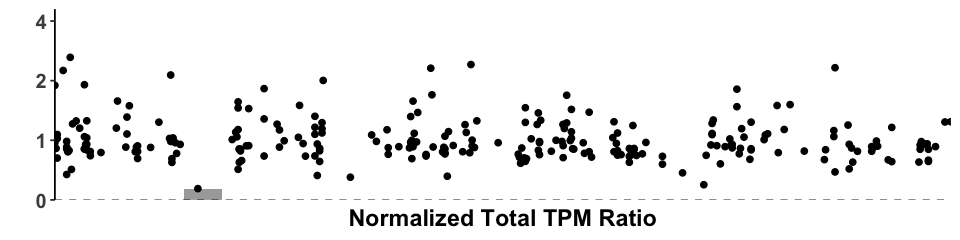

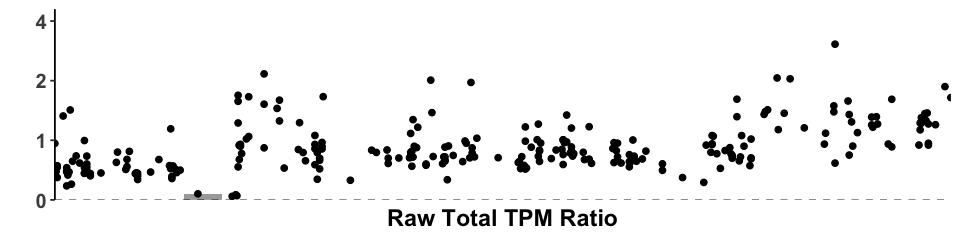

In [20]:
options(repr.plot.width=8, repr.plot.height=2)
draw_total_ratio(df_chrplot, "SP34", 4, TRUE)
draw_total_ratio(df_chrplot, "SP34", 4, FALSE)

In [21]:
draw_AS_ratio <- function(df, sample, chromnum, allele, normalized = TRUE, theme = MYTHEME){
    if(normalized){
        ystr <- paste0("ratio_", allele, "_", sample, "_display")  
        title <- paste0("Normalized Allele ", allele, " TPM ratio")
    }
    else{
        ystr <- paste0("rawratio_", allele, "_", sample, "_display")  
        title <- paste0("Raw Allele ", allele, " TPM ratio")  
    }

    if(allele == "A"){
        point_color <- "blue"
    }
    else{ # Allele B
        point_color <- "red"
    }
    
    p <- df %>%
        filter(chrom == chromnum) %>%
        ggplot() +
        geom_point(aes_string(x = "chr_loc", y = ystr), 
                   stat = "identity", color = point_color) +     
        scale_x_continuous(labels = c(), expand = c(0,0)) +
        geom_hline(yintercept = 0, color="black", alpha=0.5, linetype = "dashed") +
        scale_y_continuous(limits = c(0,3.2), breaks = c(0,1,2,3), 
                           labels = c('0', '1', '2', '4'), expand = c(0,0)) +
        labs(x = title, y = "") + theme
    
    if(chromnum == 4 & "gene_id" %in% names(df)){
        gene_loc <- df[df[["gene_id"]] == "ENSG00000169851.15", "chr_loc"]
        pv <- df[df[["gene_id"]] == "ENSG00000169851.15",][[ystr]]

        if(!is.na(pv)){
            p <- p + annotate("rect", xmin = gene_loc-3000000, xmax = gene_loc+5000000, 
                              ymin = 0, ymax = pv, alpha = .4,fill = point_color)}
    }
    return(p)
}

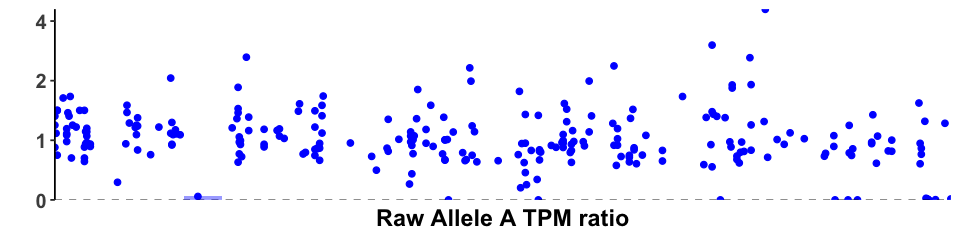

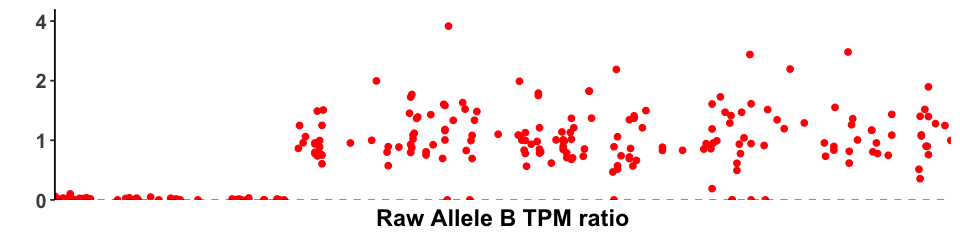

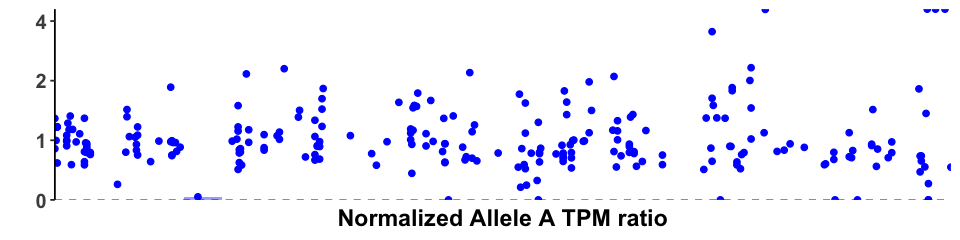

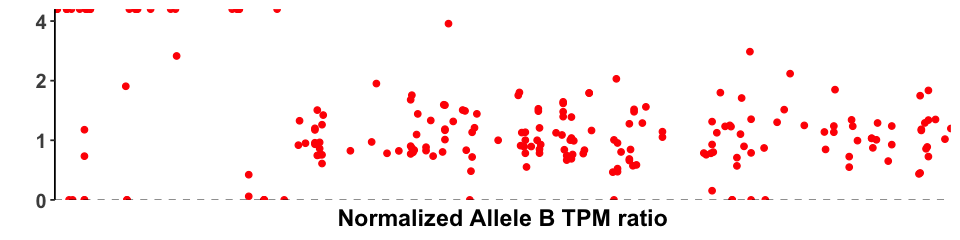

In [22]:
options(repr.plot.width=8, repr.plot.height=2)
draw_AS_ratio(df_chrplot, "SP31", chromnum = 4, allele = 'A', normalized = FALSE)
draw_AS_ratio(df_chrplot, "SP31", chromnum = 4, allele = 'B', normalized = FALSE)
draw_AS_ratio(df_chrplot, "SP31", chromnum = 4, allele = 'A', normalized = TRUE)
draw_AS_ratio(df_chrplot, "SP31", chromnum = 4, allele = 'B', normalized = TRUE)

In [23]:
dna_seq_id <- dna_seq_id %>% mutate(group := case_when(
    description == "parental subclone" ~ "Control", 
    TRUE ~ "Bridge clone")) %>%
    mutate(group_id = c(1:10, 'I','II','III','IV','V','VI',
                        'VII','VIII','IX','X','XI','XII'))

In [24]:
draw_all_by_sample_long <- function(df, cn, cn_ase, cell, chromnum, ideogram,
                               dir = "./plots/final_plots/gene_level_chr_plots/", 
                               plotwidth = 16, mod = "return", theme = MYTHEME){
    
    filename <- paste0(cell,"-", dna_seq_id[cell, "clone"],"_chr", chromnum, ".pdf")
    title <- paste0(dna_seq_id[cell, "group"], " - ", dna_seq_id[cell, "group_id"])

    df <- as.data.frame(df)
    cn <- as.data.frame(cn)
    cn_ase <- as.data.frame(cn_ase)

    # Total Copy Number
    p1 <- cn %>%
        filter(chr == paste0("chr", chromnum)) %>%
        ggplot(aes_string(x = "chr_loc")) +
        geom_point(aes_string(y = paste0("cn_", cell)), 
                   stat = "identity", color = "black") +
        geom_hline(yintercept = 0, color="black", alpha=0.5, linetype = "dashed") + 
        labs(x = "Total Copy Number", y = "") +
        theme +
        scale_x_continuous(labels = c(), expand = c(0,0)) + 
        scale_y_continuous(expand = c(0,0), limits = c(0, 4.2))
    
    # Total TPM ratio, Raw
    p2 <- draw_total_ratio(df, cell, chromnum, normalized = FALSE)
    # Total TPM ratio, Normalized
    p3 <- draw_total_ratio(df, cell, chromnum)
    
    # Allele A Copy Number
    p4 <- cn_ase %>%
        filter(chr == paste0("chr",chromnum)) %>%
        ggplot(aes_string(x = "chr_loc")) +
        geom_point(aes_string(y = paste0("cn_A_", cell)), stat = "identity", 
                   alpha = 0.8, color = "blue", lab = "Allele A") +
        geom_hline(yintercept = 0, color="black", alpha=0.5, linetype = "dashed") + 
        labs(x = "Allele A Copy Number", y = "") + theme +
        scale_x_continuous(labels = c(), expand = c(0,0)) + 
        scale_y_continuous(expand = c(0,0), limits = c(0, 3.2))
    
    # Allele A TPM ratio, Raw
    p5 <- draw_AS_ratio(df, cell, chromnum, "A", normalized = FALSE)
    # Allele A TPM ratio, Normalized
    p6 <- draw_AS_ratio(df, cell, chromnum, "A")
    
    # Allele B Copy Number
    p7 <- cn_ase %>%
        filter(chr == paste0("chr",chromnum)) %>%
        ggplot(aes_string(x = "chr_loc")) +
        geom_point(aes_string(y = paste0("cn_B_", cell)), stat = "identity", 
                   alpha = 0.8, color = "red", lab = "Allele B") +
        geom_hline(yintercept = 0, color="black", alpha=0.5, linetype = "dashed") + 
        labs(x = "Allele B Copy Number", y = "") + theme +
        scale_x_continuous(labels = c(), expand = c(0,0)) + 
        scale_y_continuous(expand = c(0,0), limits = c(0, 3.2))
    # Allele B TPM ratio, Raw
    p8 <- draw_AS_ratio(df, cell, chromnum, "B", normalized = FALSE)
    # Allele B TPM ratio, Normalized
    p9 <- draw_AS_ratio(df, cell, chromnum, "B")    

    plots <- list(p1,p2,p3,p4,p5,p6,p7,p8,p9)
    if(mod == "return"){
        return(plots)
    }
    else if(mod == "display"){
        options(repr.plot.width=plotwidth, repr.plot.height=15)
        do.call("grid.arrange", c(plots, nrow=9, top=title))
    }
    else if(mod == "save"){
        pdf(paste0(dir, filename), width = plotwidth, height=15)
        do.call("grid.arrange", c(plots, nrow=9, top=title))
        dev.off()
    }
}

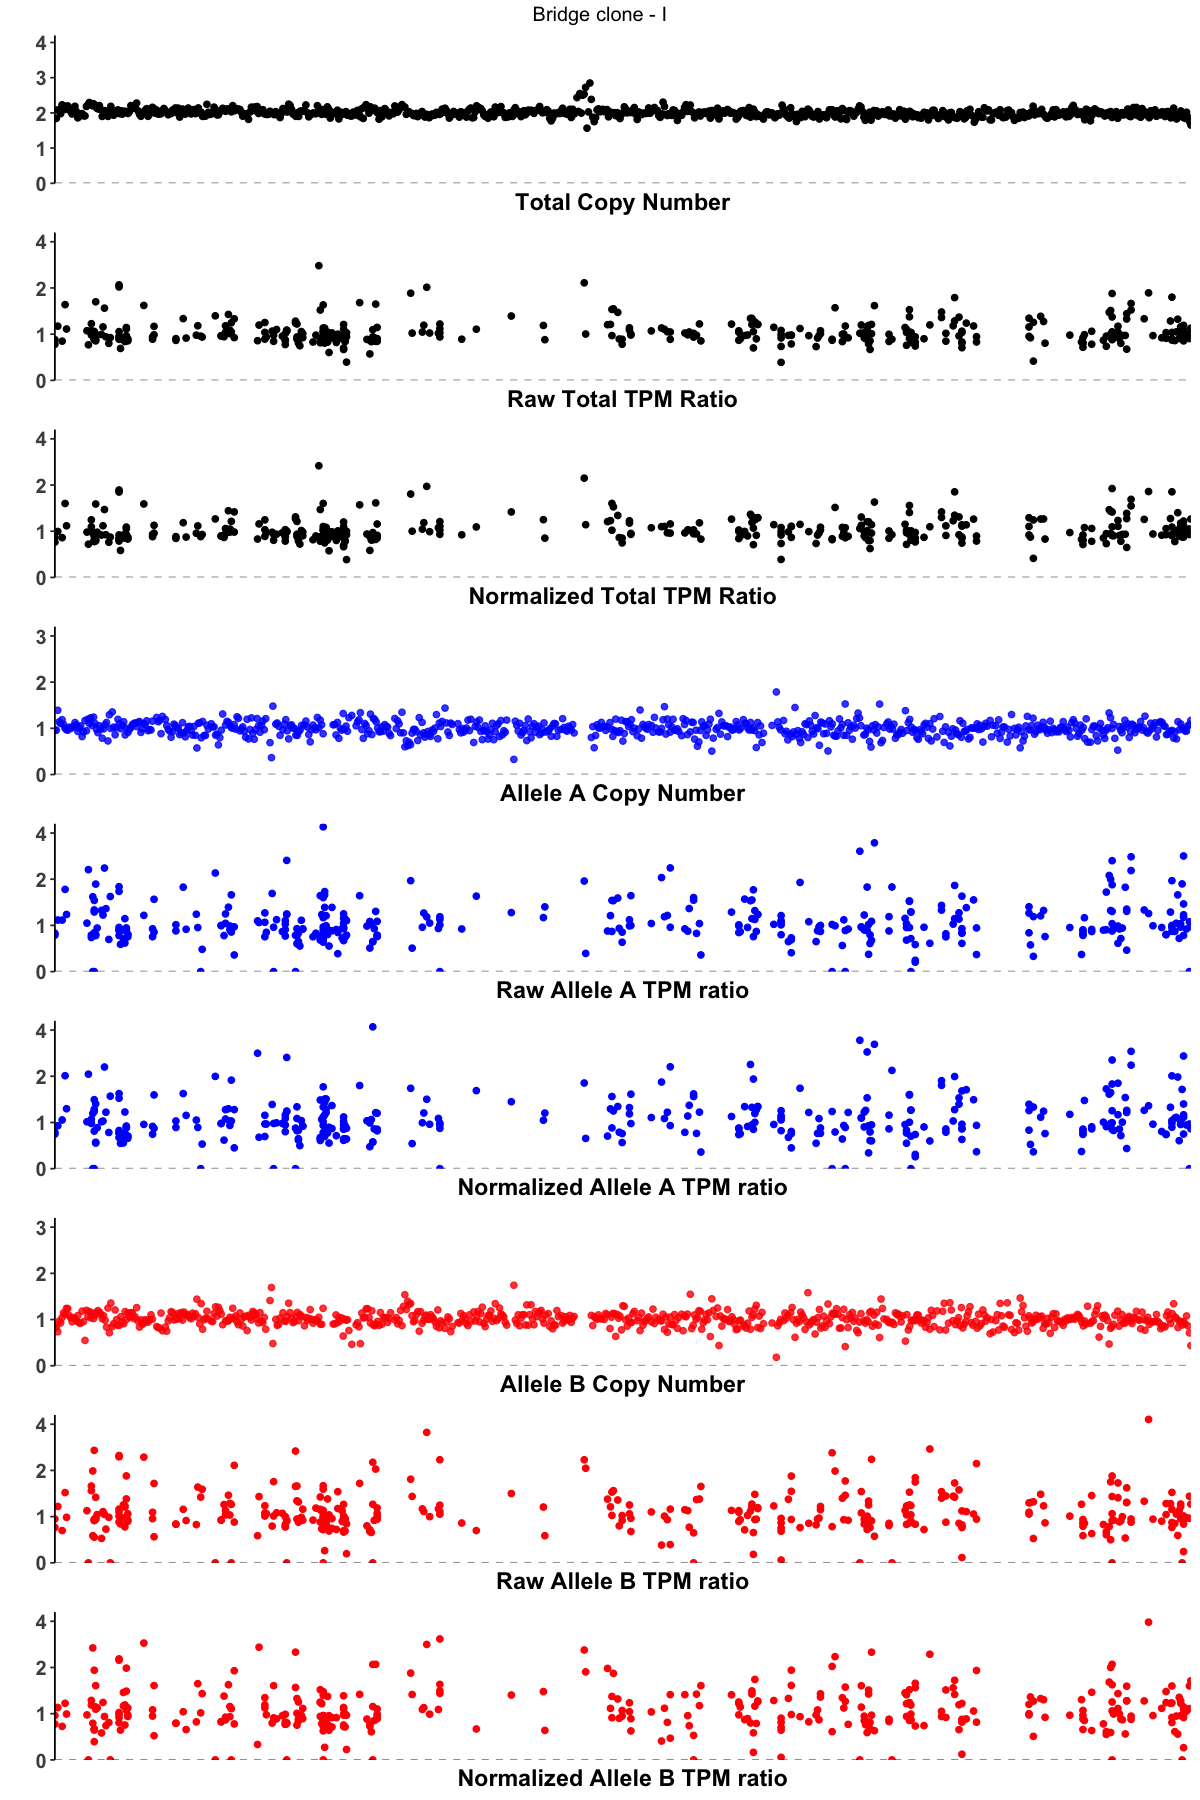

In [25]:
draw_all_by_sample_long(df_chrplot, cn_250kb, cn_ase, cell = "SP31", 
                        plotwidth = 10, chromnum = 3, mod = "display")

# Usage of function
# Specify destination directory, save plots to pdf file
# Specify chromosome num
# for(sample in samples){
#     draw_all_by_sample_long(df_chrplot, cn_250kb, cn_ase, cell = sample, 
#                             plotwidth = 12, chromnum = 3, mod = "save")
# }

In [26]:
draw_asecn_by_sample <- function(cn_ase, cell,
                                 dir = "./plots/final_plots/ase_cn_by_sample/", 
                                 plotwidth = 16, mod = "return", theme = MYTHEME){
    filename <- paste0(cell,"-", dna_seq_id[cell, "clone"],".pdf")
    title <- paste0(dna_seq_id[cell, "group"], " - ", dna_seq_id[cell, "group_id"])

    cn_ase <- as.data.frame(cn_ase)
    plot_idx <- 1
    plots <- list()
    for(chromnum in c(1:22, "X")){
        plots[[plot_idx]] <- cn_ase %>%
            filter(chr == paste0("chr",chromnum)) %>%
            ggplot(aes_string(x = "chr_loc")) +
            geom_point(aes_string(y = paste0("cn_A_", cell)), stat = "identity", 
                       alpha = 0.8, color = "blue", lab = "Allele A") +
            geom_hline(yintercept = 0, color="black", alpha=0.5, linetype = "dashed") + 
            labs(x = "", y = paste0("Chr", chromnum)) + theme +
            scale_x_continuous(expand = c(0.01,0.01), labels = scales::number_bytes_format(units = "si")) + 
            scale_y_continuous(expand = c(0,0), limits = c(0, 3.2))
        plot_idx <- plot_idx + 1
        plots[[plot_idx]] <- cn_ase %>%
            filter(chr == paste0("chr",chromnum)) %>%
            ggplot(aes_string(x = "chr_loc")) +
            geom_point(aes_string(y = paste0("cn_B_", cell)), stat = "identity", 
                       alpha = 0.8, color = "red", lab = "Allele B") +
            geom_hline(yintercept = 0, color="black", alpha=0.5, linetype = "dashed") + 
            labs(x = "", y = "") + theme +
            scale_x_continuous(expand = c(0.01,0.01), labels = scales::number_bytes_format(units = "si")) + 
            scale_y_continuous(expand = c(0,0), limits = c(0, 3.2))
        plot_idx <- plot_idx + 1
    }

    if(mod == "return"){
        return(plots)
    }
    else if(mod == "display"){
        options(repr.plot.width=plotwidth, repr.plot.height=46)
        do.call("grid.arrange", c(plots, nrow=23, top=title))
    }
    else if(mod == "save"){
        pdf(paste0(dir, filename), width = plotwidth, height=46)
        do.call("grid.arrange", c(plots, nrow=23, top=title))
        dev.off()
    }
}

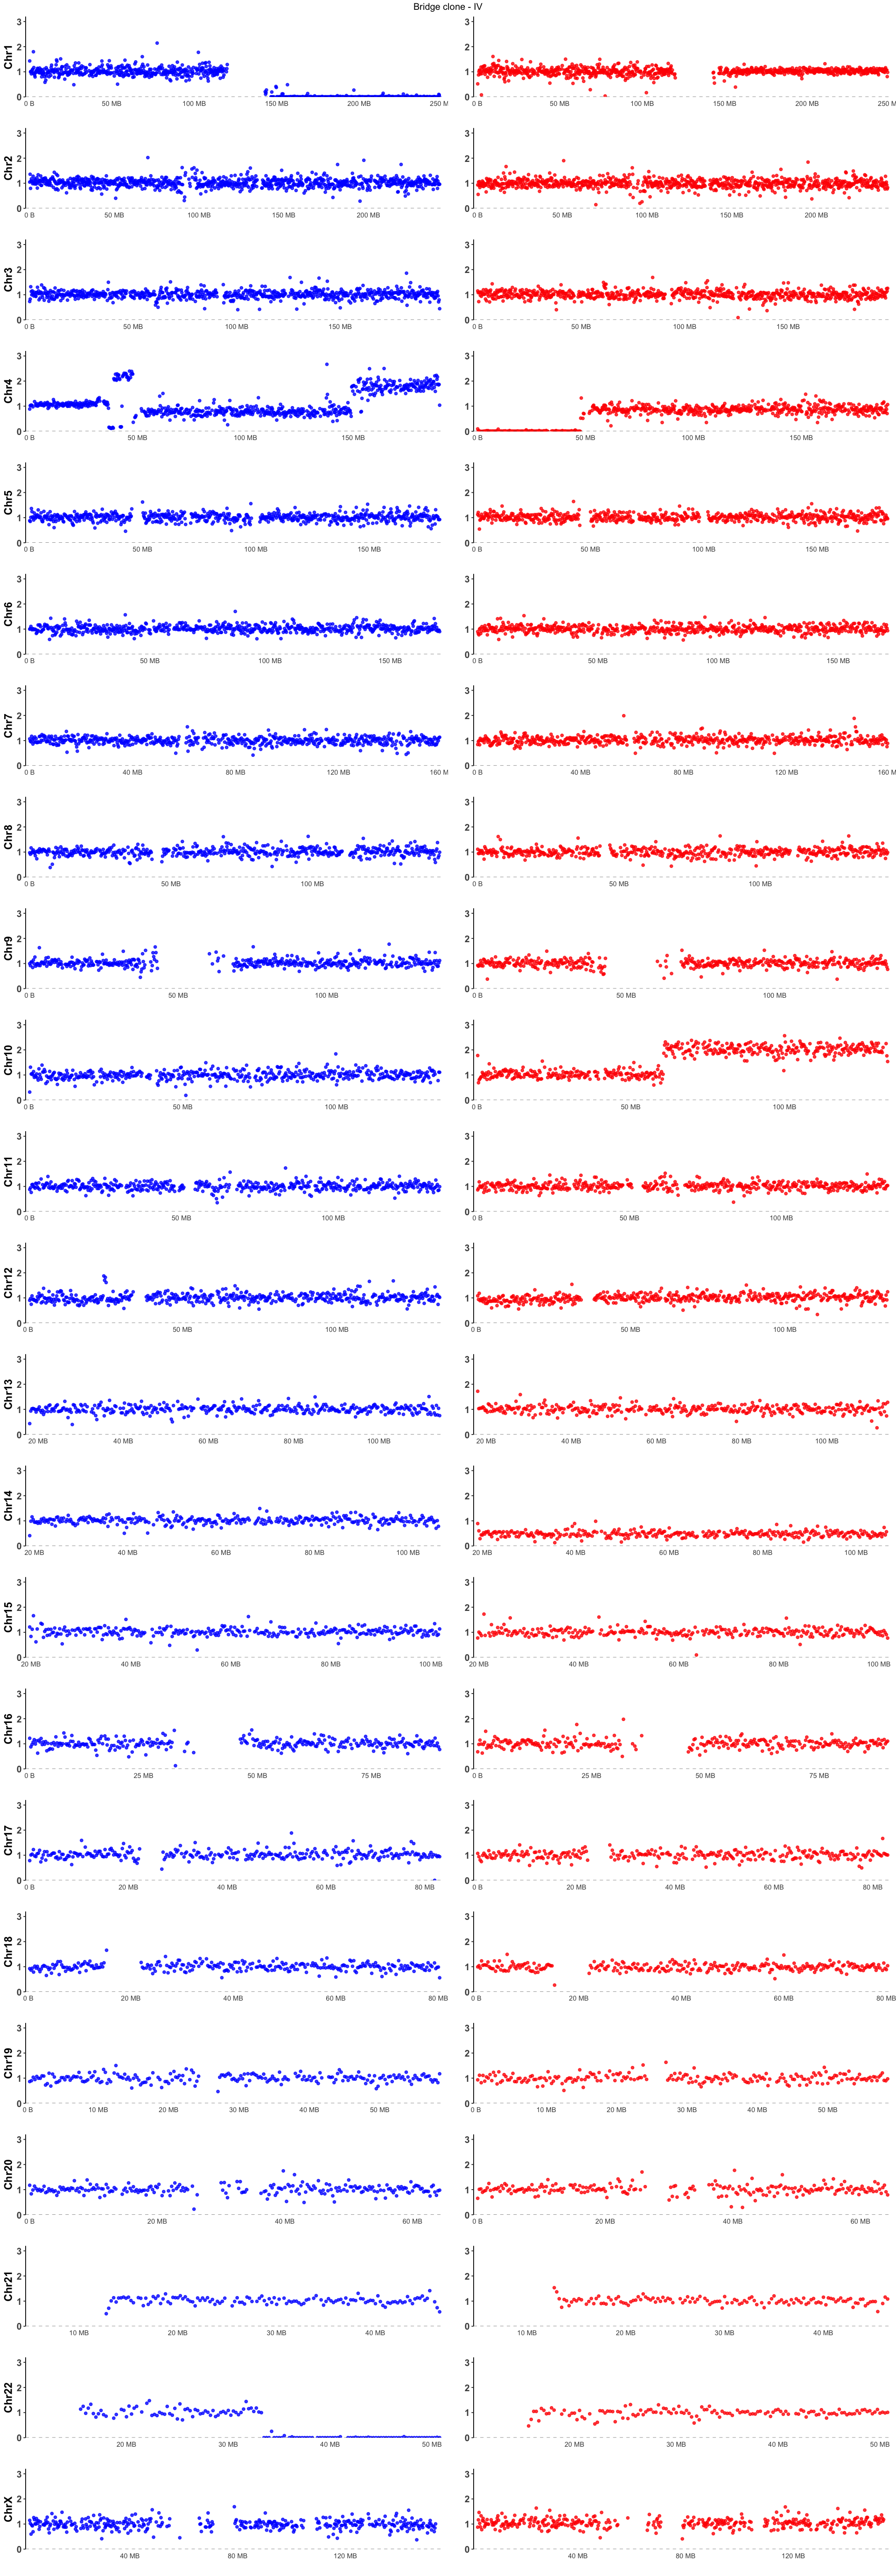

In [27]:
draw_asecn_by_sample(cn_ase, "SP34", mod = "display")
# for(sample in paste0("SP", c(1:10, 31:42))){
#     draw_asecn_by_sample(cn_ase, sample, mod = "save")
# }